# Hiv Model

Mellie Zito

In [8]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [9]:
'''Greek Alphabet:
Α α, Β β, Γ γ, Δ δ, Ε ε, Ζ ζ, Η η, Θ θ, Ι ι, Κ κ, 
Λ λ, Μ μ, Ν ν, Ξ ξ, Ο ο, Π π, Ρ ρ, 
Σ σ/ς, Τ τ, Υ υ, Φ φ, 
Χ χ, Ψ ψ, and Ω ω.
''';

For the HIV model, the system and state is created below. The state object has the 4 different types of cells, and the system object has the different rates, proportions, and the state object. The cells and rates are defined in the doc strings below. 

In [10]:
def make_system(Γ, τ, μ, β, ρ, α, δ, σ, π, dt):
    """Make a system object for the SIR model.
    R is lymphocytes
    L is latently infected cells
    E is actively infected cells
    V is free virions
    
    Γ is the rate at which new, uninfected lymphocytes (R) arise
    τ is the proportion of uninfected lymphocytes (R) that are activated
    μ is the rate uninfected lymphocytes (R) are removed by HIV-independent death
    β is the rate of infection (lymphocytes to virions)
    ρ is the proportion of cells that become latently infected (L)
    α is the rate of removal of latently infected cells (L) by activation
    δ is the rate of death of actively infected cells (E)
    σ is the rate of removal of free virions (V)
    π is rate of production of virions (V) by an actively infected cell (E)
    
    returns: System object
    """
    init = State(R=200, L=0, E=0,V=4e-7)

    t0 = 0
    t_end = 120

    return System(init=init, t0=t0, t_end=t_end,
                  Γ=Γ, τ=τ, μ=μ, β=β, ρ=ρ, α=α, δ=δ, σ=σ, π=π, dt=dt)

The virions need to be plotted separately from the other types of cells, since there is a much larger number of virions than other cells. The plot functions are created below for the virions and the other types of cells.

In [11]:
def plot_results_single(V):
    """Plot the virions from the results of a HIV model.
    
    V: TimeSeries
    
    """
    plot(V, '-', label='Virions')
    
    decorate(xlabel='Days from infection',
             ylabel='Virions')

In [12]:
def plot_results(R, L, E):
    """Plot the lymphocytes, latently infected cells, and actively infected cells from results of a HIV model.
    
    R: TimeSeries
    L: TimeSeries
    E: TimeSeries
    
    """
    plot(R, '-', label='Lymphocytes')
    plot(L, '-', label='Latently infected cells')
    plot(E, '-', label='Actively infected cells')
    
    decorate(xlabel='Days from infection',
             ylabel='Cells')

## Euler's Method

The relationships for the cells (cell death, becoming infected, new cell creation, etc.) are modeled in the differential equations. These equations and relationships are drawn from the article. The state object is then updated based on the differential equation times the set time step.

In [13]:
def update_func(state, t, system):
    """Makes the differential equations.
    
    state: State (R, L, E, V)
    t: time
    system: System object
    
    returns: State (R, L, E, V)
    """
    unpack(system)
    
    r, l, e, v = state
    
    dt = 1/10

    #dr/dt = Γτ - μr - βrv
    r_arise = Γ * τ 
    r_death = μ * r 
    r_infection = β * r * v
    
    #dl/dt = ρβRV - μL - αL
    l_infection = ρ * β * r * v
    l_death = μ * l
    l_activation = α * l
    
    #de/dt = (1-ρ)βRV + αL - δE
    e_generation = (1-ρ)* β * r * v #actively infected cells are generated immediately after infection
    e_activation = α * l
    e_death = δ * e
    
    #dv/dt = (pi)E - σV  
    v_production = π * e
    v_death = σ * v
    
    drdt = r_arise - r_death - r_infection
    dldt = l_infection - l_death - l_activation
    dedt = e_generation + e_activation - e_death
    dvdt = v_production - v_death
    
    r += drdt * dt
    l += dldt * dt
    e += dedt * dt
    v += dvdt * dt
    
    return State(R=r, L=l, E=e, V=v)

In [14]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end, dt):
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

System is initialized with all of the rates and proportions from the article, and dt is set at 1/10 (found by manually adjustment)

In [15]:
system = make_system(1.36, 0.2, 0.00136, 0.00027, 0.1, 0.036, 0.33, 2, 100, 1/10)
results = run_simulation(system, update_func);

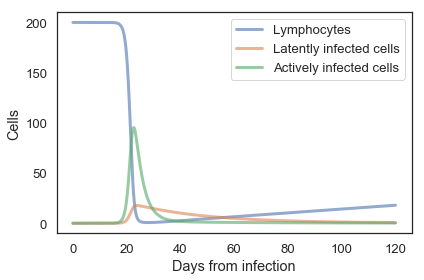

In [16]:
plot_results(results.R, results.L, results.E)

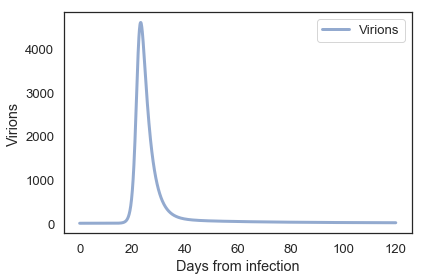

In [17]:
plot_results_single(results.V)

The plots line up fairly well with the results from the article

## ODE_solver

The relationships for the cells (cell death, becoming infected, new cell creation, etc.) are modeled in the differential equations. These equations and relationships are drawn from the article. The differential equations are returned to be used by the ode_solver.

In [121]:
def slope_func(state, t, system):
    """Makes the differential equations.
    
    state: State (R, L, E, V)
    t: time
    system: System object
    
    returns: drdt, dldt, dedt, dvdt
    """
    unpack(system)
    
    r, l, e, v = state

    #dr/dt = Γτ - μr - βrv
    r_arise = Γ * τ 
    r_death = μ * r 
    r_infection = β * r * v
    
    #dl/dt = ρβRV - μL - αL
    l_infection = ρ * β * r * v
    l_death = μ * l
    l_activation = α * l
    
    #de/dt = (1-ρ)βRV + αL - δE
    e_generation = (1-ρ)* β * r * v #actively infected cells are generated immediately after infection
    e_activation = α * l
    e_death = δ * e
    
    #dv/dt = (pi)E - σV  
    v_production = π * e
    v_death = σ * v
    
    drdt = r_arise - r_death - r_infection
    dldt = l_infection - l_death - l_activation
    dedt = e_generation + e_activation - e_death
    dvdt = v_production - v_death
    
    return drdt, dldt, dedt, dvdt

The system is initialized with the rates and proportions from the article. dt is set at 0 since its not needed by the ode_solver. The ode_solver is run and the results are used for the plots.

In [122]:
system = make_system(1.36, 0.2, 0.00136, 0.00027, 0.1, 0.036, 0.33, 2, 100, 0)
#make_system(Γ, τ, μ, β, ρ, α, δ, σ, π, dt)

slope_func(system.init, system.t0, system)
results, details = run_ode_solver(system, slope_func, max_step=1)
details

,values
sol,None
t_events,[]
nfev,884
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


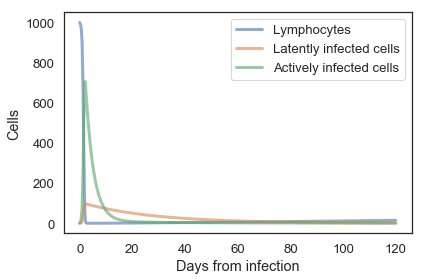

In [123]:
plot_results(results.R, results.L, results.E)

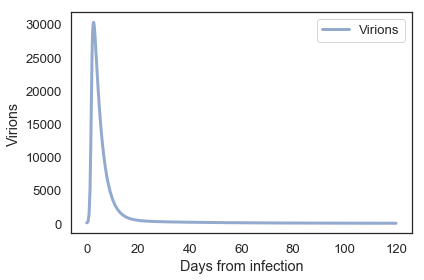

In [124]:
plot_results_single(results.V)

The plots look similar to the article and the euler's method plots.